## Exercise

Save this work in your `anomaly-detection-exercises` repository in a file named `discrete_anomaly_detection.ipynb`.

Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

### Methods covered in lesson:
- **single column count**: the number of times each unique value appears in the dataset
- **group-by count**: The number of times a combination of values appears in the dataset

# Acquire

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import env

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)

In [3]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [4]:
df = df.entry.apply(parse_log_entry)
df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [5]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb
timestamp,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246


### Method 1: single column counts.

In [51]:
df.ip.value_counts(normalize=True)

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
24.26.242.9       0.001503
68.201.219.223    0.001503
70.121.214.34     0.000143
52.87.230.102     0.000143
35.175.171.137    0.000143
54.145.52.184     0.000072
3.92.201.136      0.000072
35.174.209.2      0.000072
34.229.70.250     0.000072
54.172.14.223     0.000072
34.207.64.242     0.000072
3.88.129.158      0.000072
52.91.30.150      0.000072
52.90.165.200     0.000072
45.23.250.16      0.000072
Name: ip, dtype: float64

In [9]:
df['hour'] = df.index.hour
df['hour'].value_counts()

20    4587
21    3430
19    2244
22    1684
3      807
1      380
2      284
5      253
4      209
12      70
6       15
0        8
23       2
10       1
Name: hour, dtype: int64

<AxesSubplot:>

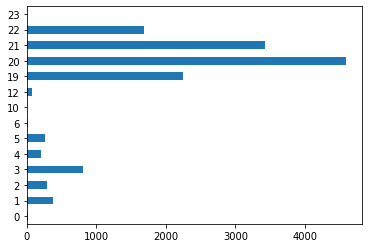

In [13]:
df['hour'].value_counts().sort_index().plot.barh()

In [14]:
df.request_method.value_counts()

GET    13974
Name: request_method, dtype: int64

In [19]:
df.request_path.value_counts()

/api/v1/sales?page=2                 709
/api/v1/items                        464
/api/v1/items?page=2                 291
/api/v1/items?page=3                 219
/api/v1/stores                       162
                                    ... 
/api/v1/items?page=0                   1
/api/v1/stores?page=999                1
/api/v1/stores?page=2                  1
/api/v1/stores?page=666                1
/api/v1/items/api/v1/items?page=3      1
Name: request_path, Length: 218, dtype: int64

In [16]:
s = '/api/v1/sales?page=81'
s.split('/')[1:]

['api', 'v1', 'sales?page=81']

In [35]:
def parse_request(string):
    out = {}
    arr = string.split('?')
    out['endpoint'] = arr[0]
    if len(arr) > 1:
        out['query'] = arr[1]
    else:
        out['query'] = ''
    return pd.Series(out)
       


In [33]:
parse_request('/api/v1/items/api/v1/items?page=3')

/api/v1/items/api/v1/items?page=3


endpoint    /api/v1/items/api/v1/items
query                           page=3
dtype: object

In [39]:
df = pd.concat([df,  df.request_path.apply(parse_request)], axis=1)
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent,size_mb,hour,endpoint,query
timestamp,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,0.488753,19,/api/v1/sales,page=81
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0.003396,19,/api/v1/items,
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0.486472,19,/api/v1/sales,page=82
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0.486377,19,/api/v1/sales,page=83
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0.488246,19,/api/v1/sales,page=84


In [40]:
df.status_code.value_counts()

200    13958
499       16
Name: status_code, dtype: int64

In [41]:
df.user_agent.value_counts()

python-requests/2.21.0                                                                                                       12001
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [50]:
df.endpoint.value_counts()

/api/v1/sales                      12403
/api/v1/items                       1065
/api/v1/stores                       229
/                                    107
/documentation                       100
/favicon.ico                          26
/api/v1//api/v1/items                 11
/api/v1/items/api/v1/items             7
/api/v1/items/next_page                5
/api/v1/                               4
/api/v1/sales/                         3
/api/v1/itemsitems                     3
/api/v1/store                          3
/api/v1items                           2
/api/v1                                1
/api/v1/helloclass!                    1
/api/v1/I_DIDNT_DO_IT!!!!              1
/api/v1/items&page=0                   1
/api/V1/HiZach!                        1
/api/v1//api/v1/items/next_page        1
Name: endpoint, dtype: int64

## Method 2: multi-column counts

In [77]:
df.groupby(['ip','endpoint']).size()


ip              endpoint      
173.173.113.51  /                   1
                /api/v1/items     188
                /api/v1/sales     815
                /api/v1/stores     54
                /documentation      1
                                 ... 
97.105.19.58    /api/v1/store       3
                /api/v1/stores    159
                /api/v1items        1
                /documentation     93
                /favicon.ico       14
Length: 61, dtype: int64

In [63]:
df.groupby(['ip','endpoint']).size().reset_index()

,ip,endpoint,0
0,173.173.113.51,/,1
1,173.173.113.51,/api/v1/items,188
2,173.173.113.51,/api/v1/sales,815
3,173.173.113.51,/api/v1/stores,54
4,173.173.113.51,/documentation,1
...,...,...,...
56,97.105.19.58,/api/v1/store,3
57,97.105.19.58,/api/v1/stores,159
58,97.105.19.58,/api/v1items,1
59,97.105.19.58,/documentation,93


In [78]:
df.groupby(['ip']).endpoint.value_counts(normalize=True)


ip              endpoint                       
173.173.113.51  /api/v1/sales                      0.769594
                /api/v1/items                      0.177526
                /api/v1/stores                     0.050992
                /                                  0.000944
                /documentation                     0.000944
                                                     ...   
97.105.19.58    /api/v1//api/v1/items/next_page    0.000083
                /api/v1/I_DIDNT_DO_IT!!!!          0.000083
                /api/v1/helloclass!                0.000083
                /api/v1/items&page=0               0.000083
                /api/v1items                       0.000083
Name: endpoint, Length: 61, dtype: float64

In [80]:
endpoint_anomalies = df.groupby(['ip']).endpoint.value_counts(normalize=True).rename('prob_endpoint_for_ip').reset_index()


In [82]:
endpoint_anomalies[endpoint_anomalies.prob_endpoint_for_ip < .01]

,ip,endpoint,prob_endpoint_for_ip
3,173.173.113.51,/,0.000944
4,173.173.113.51,/documentation,0.000944
34,72.181.105.81,/api/v1/,0.008130
35,72.181.105.81,/api/v1items,0.004065
38,72.181.113.170,/api/v1/stores,0.004894
39,72.181.113.170,/,0.001631
40,72.181.113.170,/favicon.ico,0.001631
44,97.105.19.58,/,0.007918
45,97.105.19.58,/documentation,0.007751
46,97.105.19.58,/favicon.ico,0.001167


In [84]:
df.groupby(['status_code']).endpoint.value_counts(normalize=True).rename('proba').reset_index()

,status_code,endpoint,proba
0,200,/api/v1/sales,0.887735
1,200,/api/v1/items,0.076014
2,200,/api/v1/stores,0.016406
3,200,/,0.007666
4,200,/documentation,0.007164
5,200,/favicon.ico,0.001863
6,200,/api/v1//api/v1/items,0.000788
7,200,/api/v1/items/api/v1/items,0.000502
8,200,/api/v1/items/next_page,0.000358
9,200,/api/v1/,0.000287


In [86]:
df.groupby(['status_code','endpoint']).size().reset_index().sort_values(by=0)

,status_code,endpoint,0
1,200,/api/V1/HiZach!,1
2,200,/api/v1,1
5,200,/api/v1//api/v1/items/next_page,1
6,200,/api/v1/I_DIDNT_DO_IT!!!!,1
7,200,/api/v1/helloclass!,1
9,200,/api/v1/items&page=0,1
17,200,/api/v1items,2
12,200,/api/v1/itemsitems,3
15,200,/api/v1/store,3
14,200,/api/v1/sales/,3


In [87]:
df.groupby(['status_code']).endpoint.value_counts().rename('proba').reset_index().sort_values(by='proba')

,status_code,endpoint,proba
19,200,/api/v1/items&page=0,1
18,200,/api/v1/helloclass!,1
17,200,/api/v1/I_DIDNT_DO_IT!!!!,1
16,200,/api/v1//api/v1/items/next_page,1
15,200,/api/v1,1
14,200,/api/V1/HiZach!,1
13,200,/api/v1items,2
10,200,/api/v1/itemsitems,3
12,200,/api/v1/store,3
11,200,/api/v1/sales/,3
